# **NLP - Trevor Noah**

- **Questions**:  Why do we like Trevor Noah?


- **Data cleaning**
    1. Corpus - a collection of text
    2. Document-Term Matrix - word counts in matrix format

- **EDA**
    - Top words

- **NLP**
    - Sentimental Analysis
    - Top Modeling
    - Text Generation

In [1]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

# Scrapes transcript data from scrapsfromtheloft.com
def url_to_transcript(url):
    '''Returns transcript data specifically from scrapsfromtheloft.com.'''
    page = requests.get(url).text   #get all text from this url
    soup = BeautifulSoup(page, "lxml") # read this as lxml document
    text = [p.text for p in soup.find(class_="post-content").find_all('p')] #pull out content in this class
    print(url)
    return text

# URLs of transcripts in scope
urls = ['https://scrapsfromtheloft.com/2018/11/21/trevor-noah-son-of-patricia-transcript/']

# Comedian names
comedians = ['Trevor_Noah']

In [3]:
transcripts = [url_to_transcript(u) for u in urls]

https://scrapsfromtheloft.com/2018/11/21/trevor-noah-son-of-patricia-transcript/


In [14]:
!mkdir transcripts
for i, c in enumerate(comedians):
     with open("transcripts/" + c + ".txt", "wb") as file:
         pickle.dump(transcripts[i], file)

In [16]:
# Load pickled files
data = {}
for i, c in enumerate(comedians):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)

In [17]:
data.keys()

dict_keys(['Trevor_Noah'])

In [21]:
data

{'Trevor_Noah': ['A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH',
  '[presenter] Beautiful people, put your hands together for Trevor Noah. [shouting and whooping] [hip hop intro music] [applause]',
  'What’s going on, Los Angeles? [louder cheering] Welcome to the show. Thank you for coming out. Thank you for being here. This is so much fun. Welcome out. Oh, look at all of you. This is so dope. I love LA. I love everything about LA. Even the things people hate about LA, I love. I love the traffic in LA. It’s like one of my favorite experiences. Yeah, when you don’t live here, it’s great. It’s wonderful. Because you get to be a part of it, but it’s not yours forever. It’s like anther person’s child, you know what I’m saying? Yeah, you get to be like, “This is crazy. Have it back.” -That’s what it feels like. -[laughter] -I love it, man. -[indistinct shout] I love the vibe. You know? I love driving out here. You know. And while I’m out here, I get t

In [22]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [23]:
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}
data_combined

{'Trevor_Noah': ["A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Trevor Noah. [shouting and whooping] [hip hop intro music] [applause] What’s going on, Los Angeles? [louder cheering] Welcome to the show. Thank you for coming out. Thank you for being here. This is so much fun. Welcome out. Oh, look at all of you. This is so dope. I love LA. I love everything about LA. Even the things people hate about LA, I love. I love the traffic in LA. It’s like one of my favorite experiences. Yeah, when you don’t live here, it’s great. It’s wonderful. Because you get to be a part of it, but it’s not yours forever. It’s like anther person’s child, you know what I’m saying? Yeah, you get to be like, “This is crazy. Have it back.” -That’s what it feels like. -[laughter] -I love it, man. -[indistinct shout] I love the vibe. You know? I love driving out here. You know. And while I’m out here, I get to listen t

In [26]:
# We can either keep it in dictionary format or put it into a pandas dataframe
import pandas as pd
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['transcript']
data_df = data_df.sort_index()
data_df

,transcript
Trevor_Noah,"A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre..."


In [27]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #get ride of [abc] if there's square bracket and with some characters in it.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) # W*:A-Z  d:digit
    return text

round1 = lambda x: clean_text_round1(x)

In [28]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_df.transcript.apply(round1))
data_clean

,transcript
Trevor_Noah,a netflix original comedy special live nation presents trevor noah beautiful people put your hands together for trevor noah what’s going on l...


In [29]:
# Apply a second round of cleaning  
def clean_text_round2(text):
    '''Get rid of some additional punctuation (' \) and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [39]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.transcript.apply(round2))
data_clean

,transcript
Trevor_Noah,a netflix original comedy special live nation presents trevor noah beautiful people put your hands together for trevor noah whats going on lo...


In [43]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,abandoned,accept,accommodating,accountability,acting,action,acts,actually,adamant,addressed,...,year,years,yes,yo,yogurt,york,youd,youll,youre,youve
Trevor_Noah,1,1,1,1,1,1,1,4,1,1,...,2,2,4,8,1,3,3,9,20,18


In [45]:
# Let's pickle it for later use
data_dtm.to_pickle("dtm.pkl")

# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

In [46]:
# for topic modeling
# Let's add the comedians' full names as well
full_names = ['Trevor_Noah']

data_df['full_name'] = full_names
data_df

,transcript,full_name
Trevor_Noah,"A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre...",Trevor_Noah


In [42]:
# Let's pickle it for later use
data_df.to_pickle("corpus.pkl")

## EDA

In [47]:
# Read in the document-term matrix
import pandas as pd

data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

,Trevor_Noah
abandoned,1
accept,1
accommodating,1
accountability,1
acting,1


In [136]:
# Find the top 30 words said by each comedian
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'Trevor_Noah': [('like', 205),
  ('know', 101),
  ('im', 94),
  ('dont', 73),
  ('just', 68),
  ('said', 62),
  ('snake', 59),
  ('people', 49),
  ('tacos', 48),
  ('man', 48),
  ('going', 47),
  ('right', 44),
  ('yeah', 44),
  ('thats', 44),
  ('hes', 42),
  ('time', 35),
  ('want', 33),
  ('got', 30),
  ('thing', 29),
  ('didnt', 28),
  ('theres', 28),
  ('trevor', 25),
  ('think', 25),
  ('oh', 23),
  ('food', 22),
  ('wall', 22),
  ('love', 21),
  ('ive', 21),
  ('thank', 20),
  ('youre', 20)]}

In [137]:
# Let's first pull out the top 30 words for each comedian
words = [word for (word, count) in top_dict['Trevor_Noah']]
words

['like',
 'know',
 'im',
 'dont',
 'just',
 'said',
 'snake',
 'people',
 'tacos',
 'man',
 'going',
 'right',
 'yeah',
 'thats',
 'hes',
 'time',
 'want',
 'got',
 'thing',
 'didnt',
 'theres',
 'trevor',
 'think',
 'oh',
 'food',
 'wall',
 'love',
 'ive',
 'thank',
 'youre']

In [113]:
# set a limit
# If more than 60, exclude it from the list
#add_stop_words = [word for word, count in top_dict['Trevor_Noah'] if count  > 60]
#add_stop_words

['like', 'know', 'im', 'dont', 'just', 'said']

In [117]:
add_stop_words = ['like', 'know', 'im', 'dont', 'just', 'said','going','yeah','thats','want','got','theres','oh','thank','youre']
add_stop_words

['like',
 'know',
 'im',
 'dont',
 'just',
 'said',
 'going',
 'yeah',
 'thats',
 'want',
 'got',
 'theres',
 'oh',
 'thank',
 'youre']

In [118]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text   # text:contains stop word list
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words) # English + add stop word

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")

In [119]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud
#still need stop_word. CAN'T NOT directly use cleaned data
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

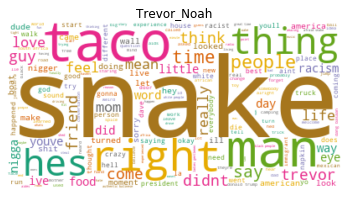

In [121]:
# Reset the output dimensions
import matplotlib.pyplot as plt


wc.generate(data_clean.transcript[comedian])

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Trevor_Noah")
    
plt.show()

In [130]:
# Find the number of unique words that each comedian uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once

unique_list=data[comedian].nonzero()[0].size

unique_list

/Users/balloon_n/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """


1240

In [142]:
data_profanity = data.transpose()[['shit']]
data_profanity

,shit
Trevor_Noah,13


## NLP

### Sentimental Analysis

In [144]:
# We'll start by reading in the corpus, which preserves word order
import pandas as pd

data = pd.read_pickle('corpus.pkl')
data

,transcript,full_name
Trevor_Noah,"A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre...",Trevor_Noah


**Sentiment Labels:** Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.
   * **Polarity**: How positive or negative a word is. -1 is very negative. +1 is very positive.
   * **Subjectivity**: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

In [145]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['transcript'].apply(pol)
data['subjectivity'] = data['transcript'].apply(sub)
data

,transcript,full_name,polarity,subjectivity
Trevor_Noah,"A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre...",Trevor_Noah,0.096365,0.4799


In [156]:
# Sentiment of Routine Over Time

# Split each routine into 10 parts
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [155]:
data.transcript

Trevor_Noah    A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre...
Name: transcript, dtype: object

In [159]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
for t in data.transcript:
    split = split_text(t)
    list_pieces.append(split)
list_pieces

[['A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Trevor Noah. [shouting and whooping] [hip hop intro music] [applause] What’s going on, Los Angeles? [louder cheering] Welcome to the show. Thank you for coming out. Thank you for being here. This is so much fun. Welcome out. Oh, look at all of you. This is so dope. I love LA. I love everything about LA. Even the things people hate about LA, I love. I love the traffic in LA. It’s like one of my favorite experiences. Yeah, when you don’t live here, it’s great. It’s wonderful. Because you get to be a part of it, but it’s not yours forever. It’s like anther person’s child, you know what I’m saying? Yeah, you get to be like, “This is crazy. Have it back.” -That’s what it feels like. -[laughter] -I love it, man. -[indistinct shout] I love the vibe. You know? I love driving out here. You know. And while I’m out here, I get to listen to the radio, yo

In [160]:
# Calculate the polarity for each piece of text

polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)
    
polarity_transcript

[[0.22278402626414004,
  0.04534116676973819,
  0.12712081128747796,
  0.1844222359123356,
  0.00010635108037707172,
  0.07658868908868909,
  -0.028631360078277875,
  0.15337370084205523,
  0.10149608328179754,
  0.03568412923881674]]

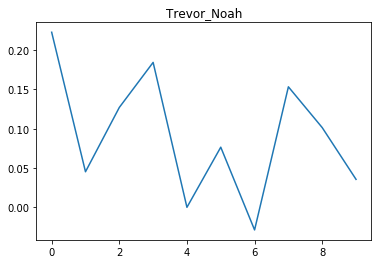

In [162]:
# Show the plot for one comedian
plt.plot(polarity_transcript[0])
plt.title(data['full_name'].index[0])
plt.show()

### Top Modeling

#### Top Modeling for all text

In [163]:
# Let's read in our document-term matrix
import pandas as pd
import pickle

data = pd.read_pickle('dtm_stop.pkl')
data

,abandoned,accept,accommodating,accountability,acting,action,acts,actually,adamant,addressed,...,yanks,year,years,yes,yo,yogurt,york,youd,youll,youve
Trevor_Noah,1,1,1,1,1,1,1,4,1,1,...,1,2,2,4,8,1,3,3,9,18


In [164]:
from gensim import matutils, models
import scipy.sparse

In [165]:
tdm = data.transpose()
tdm.head()

,Trevor_Noah
abandoned,1
accept,1
accommodating,1
accountability,1
acting,1


In [166]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [167]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())   #dictionary of key and value

In [168]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.002*"snake" + 0.002*"people" + 0.002*"man" + 0.002*"tacos" + 0.002*"right" + 0.002*"hes" + 0.001*"time" + 0.001*"thing" + 0.001*"didnt" + 0.001*"trevor"'),
 (1,
  '0.014*"snake" + 0.011*"people" + 0.011*"tacos" + 0.011*"man" + 0.010*"right" + 0.010*"hes" + 0.008*"time" + 0.007*"thing" + 0.007*"didnt" + 0.006*"think"')]

In [169]:
# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.001*"snake" + 0.001*"hes" + 0.001*"tacos" + 0.001*"people" + 0.001*"right" + 0.001*"man" + 0.001*"time" + 0.001*"thing" + 0.001*"think" + 0.001*"food"'),
 (1,
  '0.014*"snake" + 0.012*"people" + 0.012*"man" + 0.012*"tacos" + 0.011*"right" + 0.010*"hes" + 0.009*"time" + 0.007*"thing" + 0.007*"didnt" + 0.006*"trevor"'),
 (2,
  '0.002*"snake" + 0.001*"man" + 0.001*"tacos" + 0.001*"right" + 0.001*"people" + 0.001*"time" + 0.001*"hes" + 0.001*"think" + 0.001*"thing" + 0.001*"didnt"')]

In [170]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.001*"tacos" + 0.001*"snake" + 0.001*"people" + 0.001*"right" + 0.001*"man" + 0.001*"hes" + 0.001*"time" + 0.001*"thing" + 0.001*"didnt" + 0.001*"ive"'),
 (1,
  '0.001*"right" + 0.001*"snake" + 0.001*"people" + 0.001*"man" + 0.001*"tacos" + 0.001*"hes" + 0.001*"didnt" + 0.001*"time" + 0.001*"thing" + 0.001*"trevor"'),
 (2,
  '0.015*"snake" + 0.012*"people" + 0.012*"man" + 0.012*"tacos" + 0.011*"right" + 0.011*"hes" + 0.009*"time" + 0.007*"thing" + 0.007*"didnt" + 0.006*"think"'),
 (3,
  '0.001*"snake" + 0.001*"people" + 0.001*"hes" + 0.001*"man" + 0.001*"tacos" + 0.001*"right" + 0.001*"time" + 0.001*"trevor" + 0.001*"didnt" + 0.001*"thing"')]

#### Top Modeling for noun

In [171]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'   #noun : can be found link above
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [172]:
# Read in the cleaned data, before the CountVectorizer step
data_clean = pd.read_pickle('data_clean.pkl')
data_clean

,transcript
Trevor_Noah,a netflix original comedy special live nation presents trevor noah beautiful people put your hands together for trevor noah whats going on lo...


In [173]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(data_clean.transcript.apply(nouns))
data_nouns

,transcript
Trevor_Noah,comedy nation presents people hands trevor noah angeles show thank thank fun look i la everything la things people la i i traffic experiences part...


In [219]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'know', 'im', 'dont', 'just', 'said','going','yeah','thats','want','got','theres','oh','thank','youre']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.transcript)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,accountability,action,acts,administration,afraid,africa,africans,age,ah,aides,...,yall,year,years,yes,yo,yogurt,york,youd,youll,youve
Trevor_Noah,1,1,1,1,1,4,4,1,1,4,...,1,2,2,4,3,1,3,1,5,6


In [220]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [221]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.024*"people" + 0.023*"man" + 0.023*"snake" + 0.017*"hes" + 0.017*"time" + 0.015*"tacos" + 0.014*"thing" + 0.011*"wall" + 0.011*"food" + 0.010*"trevor"'),
 (1,
  '0.002*"man" + 0.002*"people" + 0.002*"snake" + 0.002*"time" + 0.002*"hes" + 0.002*"tacos" + 0.002*"thing" + 0.002*"food" + 0.002*"trevor" + 0.002*"guy"')]

In [240]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.002*"man" + 0.002*"snake" + 0.002*"hes" + 0.002*"people" + 0.002*"tacos" + 0.002*"time" + 0.002*"trevor" + 0.002*"food" + 0.002*"thing" + 0.002*"word"'),
 (1,
  '0.002*"snake" + 0.002*"man" + 0.002*"people" + 0.002*"time" + 0.002*"hes" + 0.002*"thing" + 0.002*"tacos" + 0.002*"wall" + 0.002*"trevor" + 0.002*"food"'),
 (2,
  '0.025*"people" + 0.024*"man" + 0.024*"snake" + 0.018*"time" + 0.018*"hes" + 0.016*"tacos" + 0.015*"thing" + 0.011*"food" + 0.011*"wall" + 0.011*"trevor"')]

In [241]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.002*"snake" + 0.002*"man" + 0.002*"people" + 0.002*"hes" + 0.002*"tacos" + 0.002*"thing" + 0.002*"wall" + 0.002*"time" + 0.002*"food" + 0.002*"trevor"'),
 (1,
  '0.025*"people" + 0.025*"man" + 0.024*"snake" + 0.018*"hes" + 0.018*"time" + 0.016*"tacos" + 0.015*"thing" + 0.011*"food" + 0.011*"wall" + 0.011*"trevor"'),
 (2,
  '0.002*"snake" + 0.002*"people" + 0.002*"time" + 0.002*"man" + 0.002*"tacos" + 0.002*"thing" + 0.002*"hes" + 0.002*"way" + 0.002*"wall" + 0.002*"food"'),
 (3,
  '0.002*"snake" + 0.002*"people" + 0.002*"man" + 0.002*"hes" + 0.002*"time" + 0.002*"thing" + 0.002*"tacos" + 0.002*"trevor" + 0.002*"friend" + 0.002*"mom"')]

#### Top Modeling for noun+adj

In [242]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'  #noun and adj
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.transcript.apply(nouns_adj))
data_nouns_adj

,transcript
Trevor_Noah,netflix original comedy special live nation presents noah beautiful people hands trevor noah los angeles show thank thank much fun oh look dope i ...


In [243]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words)
data_cvna = cvna.fit_transform(data_nouns_adj.transcript)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,accountability,action,acts,adamant,administration,afraid,africa,african,africans,africas,...,yall,year,years,yes,yo,yogurt,york,youd,youll,youve
Trevor_Noah,1,1,1,1,1,4,8,2,4,1,...,1,2,2,4,7,1,3,3,6,7


In [244]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [245]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.002*"man" + 0.002*"people" + 0.002*"snake" + 0.002*"tacos" + 0.002*"hes" + 0.002*"time" + 0.002*"thing" + 0.002*"wall" + 0.002*"trevor" + 0.002*"mom"'),
 (1,
  '0.019*"snake" + 0.018*"people" + 0.018*"man" + 0.014*"tacos" + 0.013*"time" + 0.013*"hes" + 0.011*"thing" + 0.008*"food" + 0.008*"wall" + 0.008*"trevor"')]

In [246]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.002*"snake" + 0.002*"man" + 0.002*"people" + 0.002*"time" + 0.001*"tacos" + 0.001*"hes" + 0.001*"thing" + 0.001*"food" + 0.001*"little" + 0.001*"word"'),
 (1,
  '0.002*"snake" + 0.002*"man" + 0.002*"people" + 0.002*"hes" + 0.002*"time" + 0.002*"tacos" + 0.002*"thing" + 0.002*"food" + 0.002*"wall" + 0.002*"racism"'),
 (2,
  '0.020*"snake" + 0.019*"people" + 0.019*"man" + 0.015*"tacos" + 0.014*"time" + 0.014*"hes" + 0.011*"thing" + 0.009*"wall" + 0.009*"food" + 0.008*"trevor"')]

In [247]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.002*"snake" + 0.002*"people" + 0.002*"man" + 0.002*"tacos" + 0.002*"time" + 0.002*"hes" + 0.001*"thing" + 0.001*"guy" + 0.001*"food" + 0.001*"ive"'),
 (1,
  '0.002*"snake" + 0.002*"man" + 0.001*"people" + 0.001*"thing" + 0.001*"time" + 0.001*"hes" + 0.001*"tacos" + 0.001*"trevor" + 0.001*"food" + 0.001*"president"'),
 (2,
  '0.001*"man" + 0.001*"tacos" + 0.001*"hes" + 0.001*"time" + 0.001*"snake" + 0.001*"people" + 0.001*"thing" + 0.001*"food" + 0.001*"guy" + 0.001*"trevor"'),
 (3,
  '0.021*"snake" + 0.019*"people" + 0.019*"man" + 0.015*"tacos" + 0.014*"hes" + 0.014*"time" + 0.012*"thing" + 0.009*"wall" + 0.009*"food" + 0.008*"trevor"')]

In [200]:
# Our final LDA model (for now)
# noun+adj  k=2

In [245]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.002*"man" + 0.002*"people" + 0.002*"snake" + 0.002*"tacos" + 0.002*"hes" + 0.002*"time" + 0.002*"thing" + 0.002*"wall" + 0.002*"trevor" + 0.002*"mom"'),
 (1,
  '0.019*"snake" + 0.018*"people" + 0.018*"man" + 0.014*"tacos" + 0.013*"time" + 0.013*"hes" + 0.011*"thing" + 0.008*"food" + 0.008*"wall" + 0.008*"trevor"')]

-- topic1 : mom trevor\
-- topic2 : snake man tacos food 


### Text Generation

In [248]:
# Read in the corpus, including punctuation!
import pandas as pd

data = pd.read_pickle('corpus.pkl')
data

,transcript,full_name
Trevor_Noah,"A NETFLIX ORIGINAL COMEDY SPECIAL [distant traffic] LIVE NATION PRESENTS TREVOR NOAH [presenter] Beautiful people, put your hands together for Tre...",Trevor_Noah


In [249]:
from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [258]:
# Create the dictionary for Ali's routine, take a look at it
tn_dict = markov_chain(data.transcript.loc['Trevor_Noah'])
tn_dict

{'A': ['NETFLIX', 'dad', 'mirror', 'life', 'food', 'lot'],
 'NETFLIX': ['ORIGINAL'],
 'ORIGINAL': ['COMEDY'],
 'COMEDY': ['SPECIAL'],
 'SPECIAL': ['[distant'],
 '[distant': ['traffic]'],
 'traffic]': ['LIVE'],
 'LIVE': ['NATION'],
 'NATION': ['PRESENTS'],
 'PRESENTS': ['TREVOR'],
 'TREVOR': ['NOAH'],
 'NOAH': ['[presenter]'],
 '[presenter]': ['Beautiful'],
 'Beautiful': ['people,'],
 'people,': ['put', 'white', 'out', 'we', 'they’re'],
 'put': ['your', 'us', 'hashtag', 'his', 'them', 'you', 'you', 'all'],
 'your': ['hands',
  'cars.',
  'friends.',
  'mom.',
  'mom.”',
  'guide.',
  'house.',
  'own',
  'wars.”',
  'first',
  'dumb',
  'dumbass',
  'immigrants,',
  'spice',
  'friend',
  'time.',
  'mouth,',
  'pants',
  'shirt…”',
  'tacos',
  'board',
  'life.',
  'parents,',
  'first',
  'racist',
  'cousin’s'],
 'hands': ['together', 'behind', 'like'],
 'together': ['for'],
 'for': ['Trevor',
  'coming',
  'being',
  'me',
  'black',
  'instance.',
  'three',
  'that',
  'a',
  'ha

In [257]:
import random

def generate_sentence(chain, count=15):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [259]:
generate_sentence(tn_dict)

'Almost hear his face like, “Ladies and we know that.” All my farm.” I feel.'